<a href="https://colab.research.google.com/github/innerproduct/basic_ml/blob/main/From_RF_to_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
# Silence warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
url = 'https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter03/census_cleaned.csv'
import pandas as pd
df = pd.read_csv(url)
df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income_ >50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Set X and y
X = df.iloc[:,:-1]
y = df.iloc[:, -1]

# OOB Score

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(oob_score=True)
rf.fit(X, y)

RandomForestClassifier(oob_score=True)

In [ ]:
rf.oob_score_

0.8549491723227174

# Warm Start

In [ ]:
rf = RandomForestClassifier(warm_start=True,
                            n_estimators=25,
                            oob_score=True)
rf.fit(X, y)
rf.oob_score_

0.8466877552900709

In [ ]:
rf.set_params(n_estimators=50)
rf.fit(X, y)
rf.oob_score_

0.8525536684991247

In [ ]:
rf.set_params(n_estimators=100)
rf.fit(X, y)
rf.oob_score_

0.855256288197537

In [ ]:
# add 50 trees
rf.set_params(n_estimators=150)
rf.fit(X, y)
rf.oob_score_

0.8558398083596941

In [ ]:
# with warm start, only 50 decision trees are added
rf.set_params(n_estimators=200)
rf.fit(X, y)
rf.oob_score_

0.8563004821719234

In [ ]:
# Build 200 decision trees from scratch - takes longer!
rf = RandomForestClassifier(warm_start=True,
                            n_estimators=200,
                            oob_score=True)
rf.fit(X, y)
rf.oob_score_

0.856607598046743

In [ ]:
# check range of 50 intervals for plot
for i in range(50, 501, 50):
  print(i)

50
100
150
200
250
300
350
400
450
500


In [ ]:
# record n_estimators using 50 trees at a time for plotting

# initialize model
rf = RandomForestClassifier(warm_start=True,
                            n_estimators=50,
                            oob_score=True)
# set up list of oob_scores
oob_scores = []

# set up list of number of trees
num_trees = []

# look through 50 trees at a time
for i in range(50, 501, 50):
  # set n_estimators
  rf.set_params(n_estimators=i)
  # fit on data
  rf.fit(X, y)
  # get oob_score
  score = rf.oob_score_
  # add oob_score to list of scores
  oob_scores.append(score)
  # add i to num_trees
  num_trees.append(i)

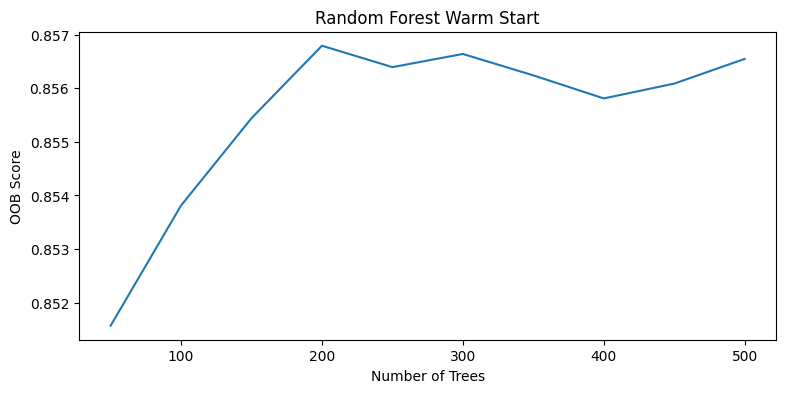

In [ ]:
# Set up plot
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 4))
plt.plot(num_trees, oob_scores)
plt.title('Random Forest Warm Start')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Score')
plt.show()

# Gradient Boosting From Scratch

In [ ]:
url = 'https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter03/bike_rentals_cleaned.csv'
import pandas as pd
df = pd.read_csv(url)
df.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [ ]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# build first decision tree (base learner)
tree_1 = DecisionTreeRegressor(max_depth=2, random_state=2)

# fit tree to data
tree_1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [ ]:
# store predictions from first tree as y_train_pred
y_train_pred = tree_1.predict(X_train)

In [ ]:
# compute residuals
y2_train = y_train - y_train_pred

In [ ]:
# build 2nd Decision Tree on residuals
tree_2 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_2.fit(X_train, y2_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [ ]:
# Repeat process of training on residuals and building new trees
# 1. Get new preds
y2_train_pred = tree_2.predict(X_train)

# 2. Compute new resids
y3_train = y2_train - y2_train_pred

# 3. Build new tree
tree_3 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_3.fit(X_train, y3_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [ ]:
# Score the model
y1_pred = tree_1.predict(X_test)
y2_pred = tree_2.predict(X_test)
y3_pred = tree_3.predict(X_test)

y_pred = y1_pred + y2_pred + y3_pred

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
rmse = MSE(y_test, y_pred)**0.5
rmse

890.6158778268225

# GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbr = GradientBoostingRegressor(max_depth=2,
                                n_estimators=3,
                                random_state=2,
                                learning_rate=1.0)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
rmse = MSE(y_test, y_pred)**0.5
rmse

890.6158778268224

In [ ]:
gbr = GradientBoostingRegressor(random_state=2)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
rmse = MSE(y_test, y_pred)**0.5
rmse

617.0319435950079

In [ ]:
gbr = GradientBoostingRegressor(max_depth=3,
                                n_estimators=100,
                                random_state=2,
                                learning_rate=0.1)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
rmse = MSE(y_test, y_pred)**0.5
rmse

617.0319435950079

In [ ]:
gbr = GradientBoostingRegressor(max_depth=2,
                                random_state=2,
                                learning_rate=1.0,
                                )
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
rmse = MSE(y_test, y_pred)**0.5
rmse

836.5454227531505

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=3,
                   learning_rate=0.1,
                   n_estimators=100,
                   random_state=2)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
rmse = MSE(y_test, y_pred)**0.5
rmse

617.2360772022322